In [5]:
C:\Users\jialitao\Documents\Project\DR\05. data\survival analysis

C:\Users\jialitao\Documents\Project\DR\05. data\survival analysis


In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('./data/tables_fms.csv')

In [3]:
df.columns

Index(['ID', 'Incident_Number', 'Train_ID', 'Incident_Start_Date',
       'Delay_Per_Train', 'Fault_Number', 'Incident_Number_',
       'Engineering_Suffix', 'System_Asset_Type', 'Route', 'Incident_Type',
       'Symptom', 'Failed_Date', 'Occured_Date', 'Rectified_Date',
       'In_Order_Date', 'journey_id', 'Asset_Number', 'ELR',
       'EQUIP_CLASS_DESC'],
      dtype='object')

In [4]:
import pandas as pd
import numpy as np

In [5]:
df.head()

,ID,Incident_Number,Train_ID,Incident_Start_Date,Delay_Per_Train,Fault_Number,Incident_Number_,Engineering_Suffix,System_Asset_Type,Route,Incident_Type,Symptom,Failed_Date,Occured_Date,Rectified_Date,In_Order_Date,journey_id,Asset_Number,ELR,EQUIP_CLASS_DESC
0,3278847,117672,461T23MG17,17/6/2018 07:00:00,12.0,717748,117672,TRACK (P.W),TRACK,LNE ROUTE,0,ASSET DEFECT,2018-06-17 05:16:00 UTC,2018-06-17 00:00:00 UTC,2018-06-17 14:15:00 UTC,2018-06-17 14:15:00 UTC,461T23MG1720180617,48075,DOL2,Track ID ...
1,3281408,117672,171A15MC17,17/6/2018 07:00:00,10.0,717748,117672,TRACK (P.W),TRACK,LNE ROUTE,0,ASSET DEFECT,2018-06-17 05:16:00 UTC,2018-06-17 00:00:00 UTC,2018-06-17 14:15:00 UTC,2018-06-17 14:15:00 UTC,171A15MC1720180617,48075,DOL2,Track ID ...
2,79500,153143,631D62MW02,2/6/2017 22:10:00,21.0,672913,153143,TRACK (P.W),TRACK,LNE ROUTE,NaN,ASSET DEFECT,2017-06-02 21:46:00 UTC,2017-06-02 00:00:00 UTC,2017-06-02 23:53:00 UTC,2017-06-02 23:53:00 UTC,631D62MW0220170206,48081,DOL2,Track ID ...
3,82771,153143,232B36M802,2/6/2017 22:10:00,18.0,672913,153143,TRACK (P.W),TRACK,LNE ROUTE,NaN,ASSET DEFECT,2017-06-02 21:46:00 UTC,2017-06-02 00:00:00 UTC,2017-06-02 23:53:00 UTC,2017-06-02 23:53:00 UTC,232B36M80220170206,48081,DOL2,Track ID ...
4,85318,153143,541D33M702,2/6/2017 22:10:00,21.0,672913,153143,TRACK (P.W),TRACK,LNE ROUTE,NaN,ASSET DEFECT,2017-06-02 21:46:00 UTC,2017-06-02 00:00:00 UTC,2017-06-02 23:53:00 UTC,2017-06-02 23:53:00 UTC,541D33M70220170206,48081,DOL2,Track ID ...


In [139]:
import lifelines
from lifelines.utils import datetimes_to_durations
from lifelines import CoxPHFitter
import lifelines as sa
import datetime as dt

In [140]:
df.drop(['Incident_Number_', 'Occured_Date', 'Rectified_Date','Incident_Start_Date','Route','Incident_Type','Symptom','Train_ID', 'Delay_Per_Train', 'journey_id'], axis=1, inplace=True)

In [141]:
df['birth'] = df['death'] = np.nan

In [142]:
df.rename(columns={'Failed_Date': 'occurred_datetime'}, inplace=True)
df.rename(columns={'In_Order_Date': 'in_order_date'}, inplace=True)

In [143]:
# Transform str to datetime and create extra day columns to remove duplicated fault entries
df['occurred_datetime_1'] = pd.to_datetime(df['occurred_datetime'], errors = 'coerce').dt.date
df['in_order_date_1'] = pd.to_datetime(df['in_order_date'], errors = 'coerce').dt.date
df['occurred_datetime'] = pd.to_datetime(df['occurred_datetime'], errors = 'coerce')
df['in_order_date'] = pd.to_datetime(df['in_order_date'], errors = 'coerce')

In [144]:
df = df.drop_duplicates(subset = ['Asset_Number','occurred_datetime_1'])
df = df.drop_duplicates(subset = ['Asset_Number','in_order_date_1'])

In [145]:
df.drop(['occurred_datetime_1','in_order_date_1'], axis=1, inplace=True)

In [146]:
# Reset dataframe index
df = df.reset_index(drop=True)

In [147]:
# Transforming 'asset_id' from float to int
df['Asset_Number']=df['Asset_Number'].astype(int)

In [148]:
df = df.sort_values(by=['Asset_Number','occurred_datetime'])
df.head()

,ID,Incident_Number,Fault_Number,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death
0,3278847,117672,717748,TRACK (P.W),TRACK,2018-06-17 05:16:00+00:00,2018-06-17 14:15:00+00:00,48075,DOL2,Track ID ...,NaN,NaN
5,3202032,39221,666402,TRACK (P.W),TRACK,2017-04-11 17:34:26+00:00,2017-04-11 19:55:01+00:00,48081,DOL2,Track ID ...,NaN,NaN
6,3078083,41379,666548,TRACK (P.W),TRACK,2017-04-12 14:54:41+00:00,2017-04-23 06:00:01+00:00,48081,DOL2,Track ID ...,NaN,NaN
7,4320270,133293,671880,TRACK (P.W),TRACK,2017-05-25 15:10:51+00:00,2017-05-26 07:50:48+00:00,48081,DOL2,Track ID ...,NaN,NaN
1,79500,153143,672913,TRACK (P.W),TRACK,2017-06-02 21:46:00+00:00,2017-06-02 23:53:00+00:00,48081,DOL2,Track ID ...,NaN,NaN


In [149]:
df.occurred_datetime.max(), df.in_order_date.max()

(Timestamp('2018-06-28 20:09:00+0000', tz='UTC'),
 Timestamp('2019-02-08 06:12:00+0000', tz='UTC'))

In [150]:
# Reset dataframe index
df = df.reset_index(drop=True)

In [151]:
# Populate Birth and Death columns based on failure and repair date
for i in range (0,len(df)):
    df.loc[i,'birth'] = df.loc[i,'in_order_date']
    
for i in range (0,len(df)-1):
    if df.loc[i,'Asset_Number'] == df.loc[i+1,'Asset_Number']:
        df.loc[i,'death'] = df.loc[i+1,'occurred_datetime']

In [152]:
df.head()

,ID,Incident_Number,Fault_Number,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death
0,3278847,117672,717748,TRACK (P.W),TRACK,2018-06-17 05:16:00+00:00,2018-06-17 14:15:00+00:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00+00:00,NaN
1,3202032,39221,666402,TRACK (P.W),TRACK,2017-04-11 17:34:26+00:00,2017-04-11 19:55:01+00:00,48081,DOL2,Track ID ...,2017-04-11 19:55:01+00:00,2017-04-12 14:54:41+00:00
2,3078083,41379,666548,TRACK (P.W),TRACK,2017-04-12 14:54:41+00:00,2017-04-23 06:00:01+00:00,48081,DOL2,Track ID ...,2017-04-23 06:00:01+00:00,2017-05-25 15:10:51+00:00
3,4320270,133293,671880,TRACK (P.W),TRACK,2017-05-25 15:10:51+00:00,2017-05-26 07:50:48+00:00,48081,DOL2,Track ID ...,2017-05-26 07:50:48+00:00,2017-06-02 21:46:00+00:00
4,79500,153143,672913,TRACK (P.W),TRACK,2017-06-02 21:46:00+00:00,2017-06-02 23:53:00+00:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00+00:00,2017-06-17 12:12:00+00:00


In [153]:
df['birth']=pd.to_datetime(df['birth'], format='%d/%m/%Y %H:%M:%S')
df['death']=pd.to_datetime(df['death'], format='%d/%m/%Y %H:%M:%S')

In [154]:
df['birth'] = df['birth'].apply(lambda d: d.replace(tzinfo=None))
df['death'] = df['death'].apply(lambda d: d.replace(tzinfo=None))
df.head()

,ID,Incident_Number,Fault_Number,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death
0,3278847,117672,717748,TRACK (P.W),TRACK,2018-06-17 05:16:00+00:00,2018-06-17 14:15:00+00:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT
1,3202032,39221,666402,TRACK (P.W),TRACK,2017-04-11 17:34:26+00:00,2017-04-11 19:55:01+00:00,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41
2,3078083,41379,666548,TRACK (P.W),TRACK,2017-04-12 14:54:41+00:00,2017-04-23 06:00:01+00:00,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51
3,4320270,133293,671880,TRACK (P.W),TRACK,2017-05-25 15:10:51+00:00,2017-05-26 07:50:48+00:00,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00
4,79500,153143,672913,TRACK (P.W),TRACK,2017-06-02 21:46:00+00:00,2017-06-02 23:53:00+00:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00


In [155]:
df['occurred_datetime']=pd.to_datetime(df['occurred_datetime'], format='%d/%m/%Y %H:%M:%S')
df['in_order_date']=pd.to_datetime(df['in_order_date'], format='%d/%m/%Y %H:%M:%S')
df['occurred_datetime'] = df['occurred_datetime'].apply(lambda d: d.replace(tzinfo=None))
df['in_order_date'] = df['in_order_date'].apply(lambda d: d.replace(tzinfo=None))
df.head()

,ID,Incident_Number,Fault_Number,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death
0,3278847,117672,717748,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT
1,3202032,39221,666402,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41
2,3078083,41379,666548,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51
3,4320270,133293,671880,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00
4,79500,153143,672913,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00


In [156]:
df.birth.max(), df.death.max()

(Timestamp('2019-02-08 06:12:00'), Timestamp('2018-06-28 20:09:00'))

In [157]:
df['timecheck']=df['birth'] > df['death']
df.head()

,ID,Incident_Number,Fault_Number,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,timecheck
0,3278847,117672,717748,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,False
1,3202032,39221,666402,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,False
2,3078083,41379,666548,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,False
3,4320270,133293,671880,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,False
4,79500,153143,672913,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,False


In [158]:
df['timecheck'].unique()

array([False,  True])

In [159]:
df.loc[df['timecheck'] == True, ['Asset_Number','occurred_datetime','in_order_date']].shape

(29, 3)

In [160]:
from datetime import timedelta
df['death'] - timedelta(5)

0                      NaT
1      2017-04-07 14:54:41
2      2017-05-20 15:10:51
3      2017-05-28 21:46:00
4      2017-06-12 12:12:00
5      2017-12-11 09:18:00
6      2017-12-18 09:57:00
7                      NaT
8      2018-05-01 17:12:00
9                      NaT
10     2017-11-30 16:45:00
11                     NaT
12                     NaT
13     2017-11-22 10:35:00
14                     NaT
15     2017-04-26 14:41:21
16     2017-05-02 11:08:34
17     2018-02-02 07:27:00
18                     NaT
19                     NaT
20     2017-04-07 17:50:19
21     2017-04-20 07:14:36
22     2017-05-21 12:53:55
23     2017-07-15 08:13:00
24     2017-10-01 08:18:00
25     2018-02-11 19:50:00
26                     NaT
27     2018-03-02 04:47:00
28                     NaT
29     2017-10-19 13:51:00
               ...        
1098                   NaT
1099                   NaT
1100                   NaT
1101   2017-03-03 11:35:14
1102   2017-05-31 05:21:00
1103   2017-07-25 09:30:00
1

In [161]:
# Assumption - for any birth date that is greater than death, we replace the birth with death date subtract 5

df.loc[df['timecheck'] == True,  'birth'] = df['death'] - timedelta(5)

In [162]:
df.head()

,ID,Incident_Number,Fault_Number,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,timecheck
0,3278847,117672,717748,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,False
1,3202032,39221,666402,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,False
2,3078083,41379,666548,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,False
3,4320270,133293,671880,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,False
4,79500,153143,672913,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,False


In [163]:
df['timecheck']=df['birth'] > df['death']

In [164]:
df.loc[df['timecheck'] == True, ['Asset_Number','occurred_datetime','in_order_date']].shape

(0, 3)

In [165]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.get_backend()


'module://ipykernel.pylab.backend_inline'

In [166]:
# left censored data - believed to be missing data issues - populated with death time minus 1 hr
df['birth']= df['birth'].fillna(df['death']-timedelta(hours=1))

In [167]:
pd.isnull(df['birth']).sum()

3

In [168]:
# drop assets that don't have birth and death
df = df.drop(df[pd.isnull(df['birth']) & pd.isnull(df['death'])].index)

In [169]:
df.shape

(1125, 13)

In [170]:
pd.isnull(df['birth']).sum()

0

In [171]:
T, E = datetimes_to_durations(df['birth'], df['death'],freq="D")

In [172]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter: fitted with 1125 observations, 734 censored>

<Figure size 864x720 with 0 Axes>

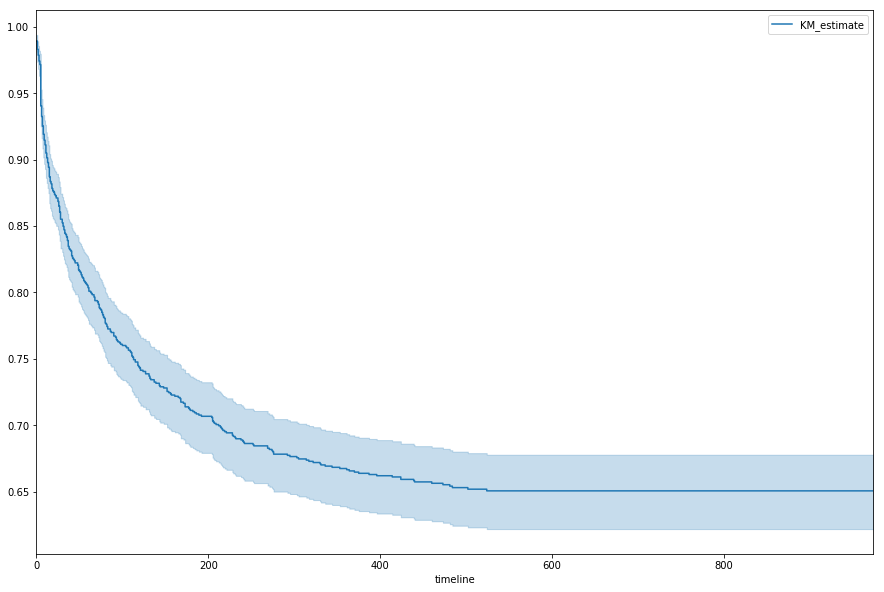

In [173]:
plt.figure(figsize=(12,10))
kmf.survival_function_
kmf.confidence_interval_
kmf.median_
kmf.plot(figsize=(15,10))

In [174]:
# Define event, which takes the value 1 if a death has been observed and 0 otherwise
# Define duration between the death and birth if a death has been observed and between today and birth otherwise
def event(df):
    if pd.isnull(df['death']) == True:
        return 0
    else:
        return 1

def duration(df):
    if pd.isnull(df['death']) == False:
        return df['death'] - df['birth']
    else:
        return pd.to_datetime('today') - df['birth']

In [175]:
df['event'] = df.apply(lambda row: event(row), axis=1)
df['duration'] = df.apply(lambda row: duration(row), axis=1)

In [176]:
df['duration'].describe()

count                        1125
mean     452 days 06:01:08.951308
std      306 days 15:30:28.759945
min               0 days 01:00:00
25%             113 days 21:50:00
50%      497 days 15:51:05.834481
75%      662 days 08:47:05.964481
max      975 days 03:02:04.773481
Name: duration, dtype: object

In [177]:
df.drop(['ID','Incident_Number','Fault_Number', 'timecheck'], axis=1, inplace=True)

In [178]:
# Convert timedelta64[ns] to float
df['T']=df['duration']/np.timedelta64(1, 'D')

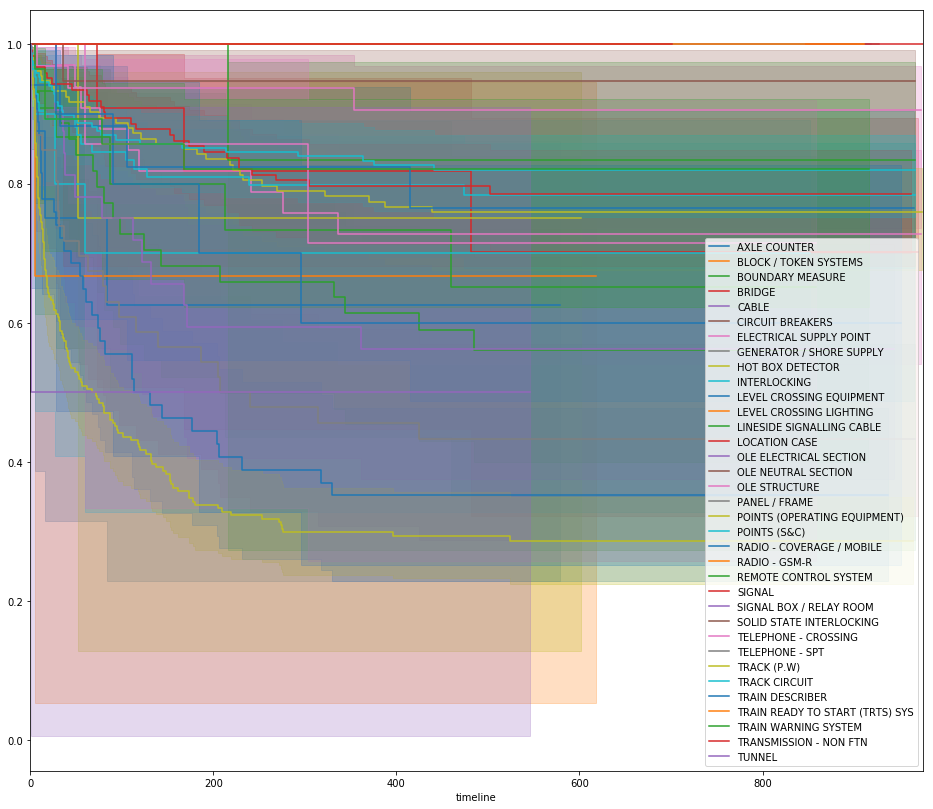

In [179]:
# Multiple groups 
plt.figure(figsize=(16,14))
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df.groupby('Engineering_Suffix'):
    kmf.fit(grouped_df["T"], grouped_df["event"], label=name)
    kmf.plot(ax=ax)

In [191]:
df.columns

Index(['Engineering_Suffix', 'System_Asset_Type', 'occurred_datetime',
       'in_order_date', 'Asset_Number', 'ELR', 'EQUIP_CLASS_DESC', 'birth',
       'death', 'event', 'duration', 'T'],
      dtype='object')

In [192]:
asset=pd.read_csv('./tables_assetline_v5.csv')

In [193]:
asset=asset[['EQUIP_NO', 'Start_Easting_centreline', 'Start_Northing_centreline', 
             'End_Easting_centreline', 'End_Northing_centreline', 'Grouping_Full_Name']]

In [194]:
#query_job = client.query("select EQUIP_NO, Start_Easting_centreline, Start_Northing_centreline, End_Easting_centreline, End_Northing_centreline, Grouping_Full_Name FROM oda.ellipse_assetlist_v5;")

In [195]:
#asset=query_job.to_dataframe()

In [196]:
asset.head()

,EQUIP_NO,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name
0,3034,NaN,NaN,NaN,NaN,Track
1,413,NaN,NaN,NaN,NaN,Track
2,537,NaN,NaN,NaN,NaN,Track
3,6797,NaN,NaN,NaN,NaN,Track
4,1976,NaN,NaN,NaN,NaN,Track


In [197]:
asset.rename(columns={'EQUIP_NO': 'Asset_Number'}, inplace=True)

In [198]:
asset.head()

,Asset_Number,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name
0,3034,NaN,NaN,NaN,NaN,Track
1,413,NaN,NaN,NaN,NaN,Track
2,537,NaN,NaN,NaN,NaN,Track
3,6797,NaN,NaN,NaN,NaN,Track
4,1976,NaN,NaN,NaN,NaN,Track


In [199]:
dfcox=df.join(asset.set_index('Asset_Number'), on='Asset_Number', how='left')

In [200]:
dfcox.head()

,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,event,duration,T,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name
0,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,0,442 days 21:47:05.719481,442.907705,433144.4903,420168.6321,428993.2115,432986.9976,Track
1,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,0 days 18:59:40,0.791435,433144.4903,420168.6321,428992.3631,432987.3366,Track
2,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,32 days 09:10:50,32.382523,433144.4903,420168.6321,428992.3631,432987.3366,Track
3,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,7 days 13:55:12,7.580000,433144.4903,420168.6321,428992.3631,432987.3366,Track
4,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,14 days 12:19:00,14.513194,433144.4903,420168.6321,428992.3631,432987.3366,Track


In [201]:
longlat=pd.read_csv('./mapping_eastings_to_longlat.csv')

In [202]:
#query_job = client.query("select * from oda.mapping_eastings_to_longlat;")

In [203]:
#longlat=query_job.to_dataframe()

In [204]:
longlat.head()

,Easting,Northing,Latitude,Longitude
0,457255.1616,447366.50,53.919303,-1.129730
1,409248.3869,422087.75,53.695167,-1.861414
2,417259.3477,421324.75,53.688108,-1.740134
3,393973.6051,399374.50,53.491060,-2.092298
4,407174.5879,413649.00,53.619350,-1.893011


In [205]:
longlat.columns = ['Start_Easting_centreline','Start_Northing_centreline', 'Latitude', 'Longitude']

In [206]:
starteasting = longlat[['Start_Easting_centreline', 'Latitude']].copy()
startnorthing = longlat[['Start_Northing_centreline', 'Longitude']].copy()

In [207]:
starteasting.head()

,Start_Easting_centreline,Latitude
0,457255.1616,53.919303
1,409248.3869,53.695167
2,417259.3477,53.688108
3,393973.6051,53.491060
4,407174.5879,53.619350


In [208]:
endlonglat = longlat[['Start_Easting_centreline','Start_Northing_centreline', 'Latitude', 'Longitude']].copy()
endlonglat.columns = ['End_Easting_centreline','End_Northing_centreline', 'Latitude', 'Longitude']

In [209]:
endeasting = endlonglat[['End_Easting_centreline', 'Latitude']].copy()
endnorthing = endlonglat[['End_Northing_centreline', 'Longitude']].copy()

In [210]:
starteasting.columns = ['Start_Easting_centreline','Start_Latitude']
startnorthing.columns = ['Start_Northing_centreline','Start_Longitude']
endeasting.columns = ['End_Easting_centreline','End_Latitude']
endnorthing.columns = ['End_Northing_centreline','End_Longitude']

In [211]:
result1 = pd.merge(dfcox, starteasting, on='Start_Easting_centreline',how='left')

In [212]:
result1.head()

,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,event,duration,T,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name,Start_Latitude
0,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,0,442 days 21:47:05.719481,442.907705,433144.4903,420168.6321,428993.2115,432986.9976,Track,53.676956
1,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,0 days 18:59:40,0.791435,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956
2,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,32 days 09:10:50,32.382523,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956
3,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,7 days 13:55:12,7.580000,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956
4,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,14 days 12:19:00,14.513194,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956


In [213]:
result2 = pd.merge(result1, startnorthing, on='Start_Northing_centreline',how='left')

In [214]:
result2.head()

,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,event,duration,T,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name,Start_Latitude,Start_Longitude
0,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,0,442 days 21:47:05.719481,442.907705,433144.4903,420168.6321,428993.2115,432986.9976,Track,53.676956,-1.499728
1,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,0 days 18:59:40,0.791435,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728
2,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,32 days 09:10:50,32.382523,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728
3,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,7 days 13:55:12,7.580000,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728
4,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,14 days 12:19:00,14.513194,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728


In [215]:
result3 = pd.merge(result2, endeasting, on='End_Easting_centreline',how='left')
result3.head()

,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,event,duration,T,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name,Start_Latitude,Start_Longitude,End_Latitude
0,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,0,442 days 21:47:05.719481,442.907705,433144.4903,420168.6321,428993.2115,432986.9976,Track,53.676956,-1.499728,53.792410
1,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,0 days 18:59:40,0.791435,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413
2,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,32 days 09:10:50,32.382523,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413
3,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,7 days 13:55:12,7.580000,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413
4,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,14 days 12:19:00,14.513194,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413


In [216]:
result4 = pd.merge(result3, endnorthing, on='End_Northing_centreline',how='left')
result4.head()

,Engineering_Suffix,System_Asset_Type,occurred_datetime,in_order_date,Asset_Number,ELR,EQUIP_CLASS_DESC,birth,death,event,...,T,Start_Easting_centreline,Start_Northing_centreline,End_Easting_centreline,End_Northing_centreline,Grouping_Full_Name,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
0,TRACK (P.W),TRACK,2018-06-17 05:16:00,2018-06-17 14:15:00,48075,DOL2,Track ID ...,2018-06-17 14:15:00,NaT,0,...,442.907705,433144.4903,420168.6321,428993.2115,432986.9976,Track,53.676956,-1.499728,53.792410,-1.561374
1,TRACK (P.W),TRACK,2017-04-11 17:34:26,2017-04-11 19:55:01,48081,DOL2,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,...,0.791435,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413,-1.561387
2,TRACK (P.W),TRACK,2017-04-12 14:54:41,2017-04-23 06:00:01,48081,DOL2,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,...,32.382523,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413,-1.561387
3,TRACK (P.W),TRACK,2017-05-25 15:10:51,2017-05-26 07:50:48,48081,DOL2,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,...,7.580000,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413,-1.561387
4,TRACK (P.W),TRACK,2017-06-02 21:46:00,2017-06-02 23:53:00,48081,DOL2,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,...,14.513194,433144.4903,420168.6321,428992.3631,432987.3366,Track,53.676956,-1.499728,53.792413,-1.561387


In [217]:
df_cox= result4[['Asset_Number','ELR', 'Grouping_Full_Name', 'Engineering_Suffix', 'System_Asset_Type', 'EQUIP_CLASS_DESC', 
                 'birth','death', 'event', 'duration', 'T', 
                 'Start_Latitude','Start_Longitude', 'End_Latitude', 'End_Longitude']].copy()

In [218]:
df_cox.head()

,Asset_Number,ELR,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,event,duration,T,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
0,48075,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2018-06-17 14:15:00,NaT,0,442 days 21:47:05.719481,442.907705,53.676956,-1.499728,53.792410,-1.561374
1,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,0 days 18:59:40,0.791435,53.676956,-1.499728,53.792413,-1.561387
2,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,32 days 09:10:50,32.382523,53.676956,-1.499728,53.792413,-1.561387
3,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,7 days 13:55:12,7.580000,53.676956,-1.499728,53.792413,-1.561387
4,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,14 days 12:19:00,14.513194,53.676956,-1.499728,53.792413,-1.561387


In [240]:
weather = pd.read_csv('wheater_names_loc.csv')

In [241]:
weather.head()

,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1375315200,2013-08-01 00:00:00 +0000 UTC,2633352,York,53.96,-1.0873,292.24,286.15,297.15,1011,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,Sky is Clear,01n
1,1375318800,2013-08-01 01:00:00 +0000 UTC,2633352,York,53.96,-1.0873,293.35,286.15,299.15,1012,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
2,1375322400,2013-08-01 02:00:00 +0000 UTC,2633352,York,53.96,-1.0873,294.45,286.15,301.15,1012,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1375326000,2013-08-01 03:00:00 +0000 UTC,2633352,York,53.96,-1.0873,293.65,286.15,302.15,1004,...,NaN,NaN,NaN,NaN,NaN,48,802,Clouds,scattered clouds,03n
4,1375329600,2013-08-01 04:00:00 +0000 UTC,2633352,York,53.96,-1.0873,296.01,287.15,303.15,1012,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d


In [221]:
# Create dictionary containing the lat and long values of the 5 weather stations in our weather data
station_location = {'Huddersfield': [53.6458, -1.785],
                    'Leeds': [53.8008, -1.5491],
                    'Manchester': [53.4808, -2.2426],
                    'Mirfield': [53.6801, -1.6967],
                    'York': [53.96, -1.0873]
                   }

In [222]:
df_cox['midpoint_Latitude'] = (df_cox['Start_Latitude']+df_cox['End_Latitude'])/2
df_cox['midpoint_Longitude'] = (df_cox['Start_Longitude']+df_cox['End_Longitude'])/2

In [223]:
df_cox.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 0 to 1124
Data columns (total 17 columns):
Asset_Number          1125 non-null int32
ELR                   1125 non-null object
Grouping_Full_Name    1100 non-null object
Engineering_Suffix    1125 non-null object
System_Asset_Type     1125 non-null object
EQUIP_CLASS_DESC      1125 non-null object
birth                 1125 non-null datetime64[ns]
death                 391 non-null datetime64[ns]
event                 1125 non-null int64
duration              1125 non-null timedelta64[ns]
T                     1125 non-null float64
Start_Latitude        1125 non-null float64
Start_Longitude       1125 non-null float64
End_Latitude          1074 non-null float64
End_Longitude         1074 non-null float64
midpoint_Latitude     1074 non-null float64
midpoint_Longitude    1074 non-null float64
dtypes: datetime64[ns](2), float64(7), int32(1), int64(1), object(5), timedelta64[ns](1)
memory usage: 153.8+ KB


In [224]:
# Create function that calculates the distance between two geographical points using the Haversine formula
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) 

In [225]:
# Create function that finds the nearest weather station from a specified location
def minimise(df_cox, station_location):
    d = {}
    for key in station_location:
        d[key] = distance(df_cox['midpoint_Latitude'], df_cox['midpoint_Longitude'], station_location[key][0],station_location[key][1])
    return min(d, key=d.get)

In [226]:
weather.columns

Index(['dt', 'dt_iso', 'city_id', 'city_name', 'lat', 'lon', 'temp',
       'temp_min', 'temp_max', 'pressure', 'sea_level', 'grnd_level',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'rain_24h',
       'rain_today', 'snow_1h', 'snow_3h', 'snow_24h', 'snow_today',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [227]:
# Populate dataframe with results from 'minimise' function
df_cox['weather_station'] = df_cox.apply(lambda row: minimise(row, station_location), axis=1)

In [228]:
df_cox.head()

,Asset_Number,ELR,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,event,duration,T,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,midpoint_Latitude,midpoint_Longitude,weather_station
0,48075,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2018-06-17 14:15:00,NaT,0,442 days 21:47:05.719481,442.907705,53.676956,-1.499728,53.792410,-1.561374,53.734683,-1.530551,Leeds
1,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-04-11 19:55:01,2017-04-12 14:54:41,1,0 days 18:59:40,0.791435,53.676956,-1.499728,53.792413,-1.561387,53.734684,-1.530557,Leeds
2,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-04-23 06:00:01,2017-05-25 15:10:51,1,32 days 09:10:50,32.382523,53.676956,-1.499728,53.792413,-1.561387,53.734684,-1.530557,Leeds
3,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-05-26 07:50:48,2017-06-02 21:46:00,1,7 days 13:55:12,7.580000,53.676956,-1.499728,53.792413,-1.561387,53.734684,-1.530557,Leeds
4,48081,DOL2,Track,TRACK (P.W),TRACK,Track ID ...,2017-06-02 23:53:00,2017-06-17 12:12:00,1,14 days 12:19:00,14.513194,53.676956,-1.499728,53.792413,-1.561387,53.734684,-1.530557,Leeds


In [245]:
weather = pd.read_csv('wheater_names_loc.csv')

In [246]:
weather.head()

,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1375315200,2013-08-01 00:00:00 +0000 UTC,2633352,York,53.96,-1.0873,292.24,286.15,297.15,1011,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,Sky is Clear,01n
1,1375318800,2013-08-01 01:00:00 +0000 UTC,2633352,York,53.96,-1.0873,293.35,286.15,299.15,1012,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
2,1375322400,2013-08-01 02:00:00 +0000 UTC,2633352,York,53.96,-1.0873,294.45,286.15,301.15,1012,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1375326000,2013-08-01 03:00:00 +0000 UTC,2633352,York,53.96,-1.0873,293.65,286.15,302.15,1004,...,NaN,NaN,NaN,NaN,NaN,48,802,Clouds,scattered clouds,03n
4,1375329600,2013-08-01 04:00:00 +0000 UTC,2633352,York,53.96,-1.0873,296.01,287.15,303.15,1012,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d


In [235]:
#  weather.columns=['dt', 'dt_iso', 'city_id', 'temp', 'temp_min', 'temp_max', 'pressure',
#        'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'rain_24h',
#        'rain_today', 'snow_1h', 'snow_3h', 'snow_24h', 'snow_today',
#        'clouds_all', 'weather_id', 'weather_main', 'weather_description',
#        'weather_icon']

In [247]:
# Remove trailing ' +0000 UTC' characters from dt_iso
weather['dt_iso'] = weather['dt_iso'].str[:-10]

In [251]:
weather.head()

,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1375315200,2013-08-01 00:00:00,2633352,York,53.96,-1.0873,292.24,286.15,297.15,1011,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,Sky is Clear,01n
1,1375318800,2013-08-01 01:00:00,2633352,York,53.96,-1.0873,293.35,286.15,299.15,1012,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
2,1375322400,2013-08-01 02:00:00,2633352,York,53.96,-1.0873,294.45,286.15,301.15,1012,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1375326000,2013-08-01 03:00:00,2633352,York,53.96,-1.0873,293.65,286.15,302.15,1004,...,NaN,NaN,NaN,NaN,NaN,48,802,Clouds,scattered clouds,03n
4,1375329600,2013-08-01 04:00:00,2633352,York,53.96,-1.0873,296.01,287.15,303.15,1012,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d


In [249]:
# Transform date str into datetime
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

In [90]:
weather.columns

Index(['dt', 'dt_iso', 'city_id', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'rain_24h',
       'rain_today', 'snow_1h', 'snow_3h', 'snow_24h', 'snow_today',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [252]:
# Drop all columns not used in analysis
weather.drop(weather.columns.difference(['city_name','dt_iso','temp','temp_min', 'temp_max',
                                         'pressure','humidity','wind_speed', 'clouds_all',
                                        'weather_main']),axis = 1, inplace=True)

In [82]:
query_job = client.query("select Asset_Number, count(Work_Order_Closed_Date) as Sum from oda.ellipse_workorder_history GROUP BY Asset_Number order by Sum desc;")

In [83]:
fre=query_job.to_dataframe()

In [84]:
fre.head()

,Asset_Number,Sum
0,967670,2192
1,2459866,2059
2,2459754,2059
3,1855630,2052
4,1855633,2052


In [85]:
fre['Sum']=fre['Sum'].astype(float)
fre['Asset_Number']=fre['Asset_Number'].astype(float)

In [86]:
df_cox=df_cox.join(fre.set_index('Asset_Number'), on='Asset_Number', how = 'left')

In [87]:
df_cox.columns

Index(['Asset_Number', 'ELR', 'Grouping_Full_Name', 'Engineering_Suffix',
       'System_Asset_Type', 'EQUIP_CLASS_DESC', 'birth', 'death', 'event',
       'duration', 'T', 'Start_Latitude', 'Start_Longitude', 'End_Latitude',
       'End_Longitude', 'midpoint_Latitude', 'midpoint_Longitude',
       'weather_station', 'Sum'],
      dtype='object')

In [93]:
df_cox_saved=df_cox.copy()

In [94]:
df_cox_saved.columns

Index(['Asset_Number', 'ELR', 'Grouping_Full_Name', 'Engineering_Suffix',
       'System_Asset_Type', 'EQUIP_CLASS_DESC', 'birth', 'death', 'event',
       'duration', 'T', 'Start_Latitude', 'Start_Longitude', 'End_Latitude',
       'End_Longitude', 'midpoint_Latitude', 'midpoint_Longitude',
       'weather_station'],
      dtype='object')

In [ ]:
# Master dataset complete
# High level asset grouping done in Excel

In [87]:
# Load master dataset with high level asset grouping

df_cox=pd.read_csv('df_cox_master.csv')
df_cox.columns

Index(['Asset_Number', 'ELR', 'High_Level_Asset_Class', 'Asset_Class_Grouping',
       'Grouping_Full_Name', 'Engineering_Suffix', 'System_Asset_Type',
       'EQUIP_CLASS_DESC', 'birth', 'death', 'event', 'duration', 'T',
       'Start_Latitude', 'Start_Longitude', 'End_Latitude', 'End_Longitude',
       'midpoint_Latitude', 'midpoint_Longitude', 'weather_station', 'Sum'],
      dtype='object')

In [253]:
df_cox_J=pd.read_csv('df_cox_master_J.csv')
df_cox_J.columns

Index(['Asset_Number', 'ELR', 'Grouping_Full_Name', 'Engineering_Suffix',
       'System_Asset_Type', 'EQUIP_CLASS_DESC', 'birth', 'death', 'event',
       'duration', 'T', 'Start_Latitude', 'Start_Longitude', 'End_Latitude',
       'End_Longitude', 'midpoint_Latitude', 'midpoint_Longitude',
       'weather_station', 'Sum', 'High_Level_Asset_Class',
       'Asset_Class_Grouping'],
      dtype='object')

In [ ]:
df_cox_saved.to_csv('cox_without.csv')

In [ ]:
# from this point forward we use the file created with our classification

In [254]:
df_cox=df_cox_J[['Asset_Number', 'ELR', 'High_Level_Asset_Class', 'Asset_Class_Grouping',
       'Grouping_Full_Name', 'Engineering_Suffix', 'System_Asset_Type',
       'EQUIP_CLASS_DESC', 'birth', 'death', 'event', 'duration', 'T',
       'Start_Latitude', 'Start_Longitude', 'End_Latitude', 'End_Longitude',
       'midpoint_Latitude', 'midpoint_Longitude', 'weather_station', 'Sum']]

In [255]:
df_cox.isnull().sum()  ## WE leave it here

Asset_Number                0
ELR                         0
High_Level_Asset_Class      0
Asset_Class_Grouping        0
Grouping_Full_Name         25
Engineering_Suffix          0
System_Asset_Type           0
EQUIP_CLASS_DESC            0
birth                       0
death                     636
event                       0
duration                    0
T                           0
Start_Latitude              0
Start_Longitude             0
End_Latitude               34
End_Longitude              34
midpoint_Latitude          34
midpoint_Longitude         34
weather_station             0
Sum                       292
dtype: int64

In [256]:
df_cox[df_cox['End_Latitude'].isnull()]

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,duration,T,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,midpoint_Latitude,midpoint_Longitude,weather_station,Sum
55,2558617,HUL4,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - HEADSPAN ANCHOR,UI - OLE Structure ...,2018-04-06 14:45:00 UTC,2018-04-13 16:29:00 UTC,...,7 days 01:44:00.000000000,7.072222,53.791585,-1.511601,NaN,NaN,NaN,NaN,Huddersfield,5.0
56,2558617,HUL4,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - HEADSPAN ANCHOR,UI - OLE Structure ...,2018-04-13 18:00:00 UTC,2017-04-17 05:55:00 UTC,...,-362 days +11:55:00.000000000,-361.503472,53.791585,-1.511601,NaN,NaN,NaN,NaN,Huddersfield,5.0
57,2402964,HUL4,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - MAST,UI - OLE Structure ...,2017-01-15 20:36:01 UTC,NaN,...,956 days 17:57:26.082030000,956.748219,53.796622,-1.531652,NaN,NaN,NaN,NaN,Huddersfield,1.0
58,1054743,DOL2,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - PORTAL,UI - OLE Structure ...,2018-04-14 01:24:00 UTC,NaN,...,503 days 13:09:27.024781000,503.548229,53.793762,-1.550760,NaN,NaN,NaN,NaN,Huddersfield,4.0
59,2558608,HUL4,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - PORTAL,UI - OLE Structure ...,2018-02-25 04:30:00 UTC,NaN,...,551 days 10:03:27.090712000,551.419064,53.794881,-1.542866,NaN,NaN,NaN,NaN,Huddersfield,6.0
60,2558343,HUL4,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - HEADSPAN,UI - OLE Structure ...,2017-06-05 10:40:00 UTC,NaN,...,816 days 03:53:27.090512000,816.162119,53.791502,-1.503980,NaN,NaN,NaN,NaN,Huddersfield,6.0
61,1624700,HAJ,E&P,OLE,OLE,SIGNAL,SIGNAL HEAD - 2 ASPECT,UI - OLE Structure ...,2018-04-10 00:30:00 UTC,NaN,...,507 days 14:03:27.059525000,507.585730,53.456634,-2.067150,NaN,NaN,NaN,NaN,Huddersfield,NaN
62,1624685,HAJ,E&P,OLE,OLE,SIGNAL,SIGNAL HEAD - 3 ASPECT,UI - OLE Structure ...,2018-04-23 07:27:00 UTC,NaN,...,494 days 07:06:27.059297000,494.296147,53.461603,-2.080516,NaN,NaN,NaN,NaN,Huddersfield,NaN
63,990439,ECM4,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - CANTILEVER,UI - OLE Structure ...,2018-03-17 10:15:00 UTC,NaN,...,531 days 04:18:26.993259000,531.179479,53.957272,-1.093735,NaN,NaN,NaN,NaN,Huddersfield,NaN
64,992941,ECM3,E&P,OLE,OLE,OLE STRUCTURE,OLE STRUCT - CANTILEVER,UI - OLE Structure ...,2018-02-24 10:26:00 UTC,NaN,...,552 days 04:07:26.993676000,552.171840,53.727598,-1.092213,NaN,NaN,NaN,NaN,Huddersfield,NaN


In [257]:
df_cox['End_Latitude']=df_cox['End_Latitude'].fillna(df_cox['Start_Latitude'])
df_cox['End_Longitude']=df_cox['End_Longitude'].fillna(df_cox['Start_Longitude'])
df_cox['midpoint_Latitude']=df_cox['midpoint_Latitude'].fillna(df_cox['Start_Latitude'])
df_cox['midpoint_Longitude']=df_cox['midpoint_Longitude'].fillna(df_cox['Start_Longitude'])

In [258]:
df_cox['Grouping_Full_Name']=df_cox['Grouping_Full_Name'].fillna('NA')

In [259]:
df_cox.isnull().sum()

Asset_Number                0
ELR                         0
High_Level_Asset_Class      0
Asset_Class_Grouping        0
Grouping_Full_Name          0
Engineering_Suffix          0
System_Asset_Type           0
EQUIP_CLASS_DESC            0
birth                       0
death                     636
event                       0
duration                    0
T                           0
Start_Latitude              0
Start_Longitude             0
End_Latitude                0
End_Longitude               0
midpoint_Latitude           0
midpoint_Longitude          0
weather_station             0
Sum                       292
dtype: int64

In [260]:
df_cox.to_csv('df_cox_master_vJ.1.csv')

In [261]:
df_cox.drop(['Start_Latitude','Start_Longitude',
             'End_Latitude','End_Longitude',
             'midpoint_Latitude', 'midpoint_Longitude'], axis=1, inplace=True)

In [262]:
df_cox.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,event,duration,T,weather_station,Sum
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01 UTC,NaN,0,923 days 10:33:25.995877000,923.439884,Leeds,113.0
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00 UTC,NaN,0,785 days 08:23:27.059722000,785.349619,Manchester,101.0
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01 UTC,NaN,0,833 days 23:03:26.026606000,833.960718,York,24.0
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01 UTC,NaN,0,830 days 04:27:26.108569000,830.185719,York,19.0
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00 UTC,2018-04-12 13:13:00 UTC,1,-56 days +17:07:00.000000000,-55.286806,York,19.0


In [263]:
# Problem with negativos

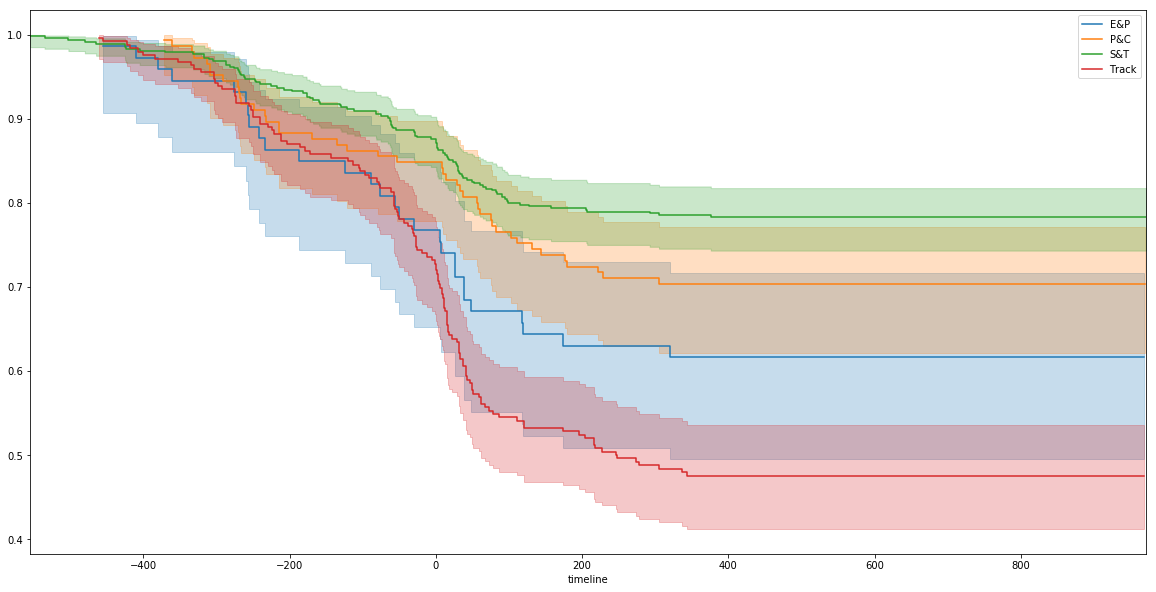

In [264]:
# KM curve for Multiple asset classess
fig, ax = plt.subplots(figsize=(20, 10))

kmf = KaplanMeierFitter()

for name, grouped_df in df_cox.groupby('High_Level_Asset_Class'):
    kmf.fit(grouped_df["T"], grouped_df["event"], label=name)
    kmf.plot(ax=ax)

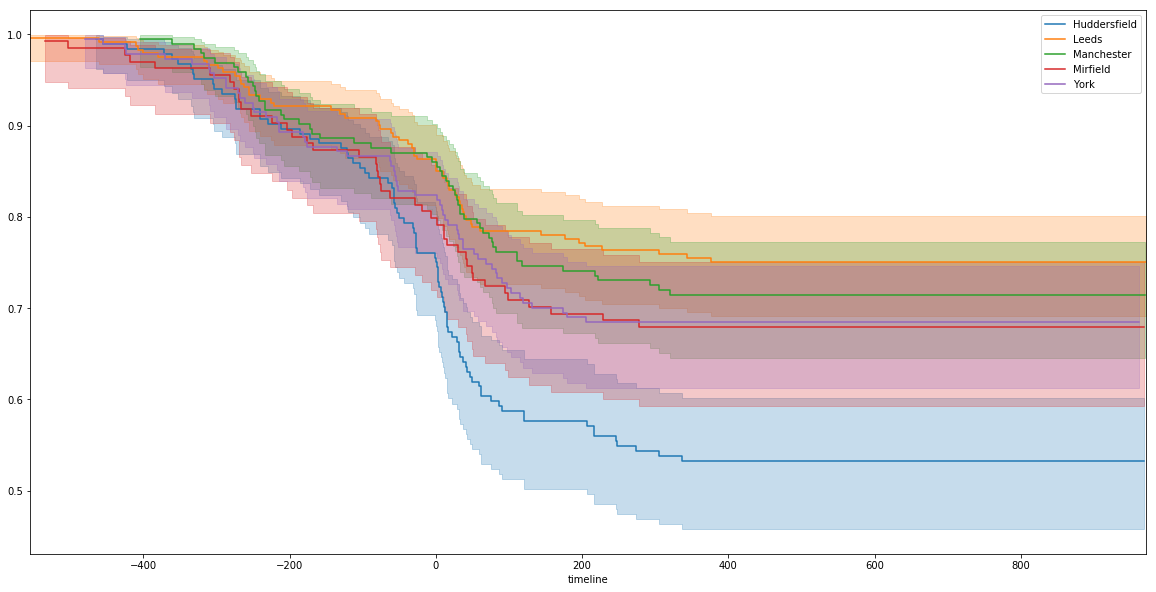

In [265]:
# KM curve for Multiple asset classess
fig, ax = plt.subplots(figsize=(20, 10))

kmf = KaplanMeierFitter()

for name, grouped_df in df_cox.groupby('weather_station'):
    kmf.fit(grouped_df["T"], grouped_df["event"], label=name)
    kmf.plot(ax=ax)

In [266]:
#Feature engineering for weather

In [267]:
weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,weather_main
0,2013-08-01 00:00:00,York,292.24,286.15,297.15,1011,93,3,0,Clear
1,2013-08-01 01:00:00,York,293.35,286.15,299.15,1012,100,2,20,Clouds
2,2013-08-01 02:00:00,York,294.45,286.15,301.15,1012,100,2,20,Clouds
3,2013-08-01 03:00:00,York,293.65,286.15,302.15,1004,48,2,48,Clouds
4,2013-08-01 04:00:00,York,296.01,287.15,303.15,1012,93,2,40,Clouds
5,2013-08-01 05:00:00,York,296.56,287.15,304.15,1012,93,3,40,Clouds
6,2013-08-01 06:00:00,York,292.64,287.15,304.15,1012,82,2,0,Clear
7,2013-08-01 07:00:00,York,297.56,288.15,305.15,1013,87,4,20,Clouds
8,2013-08-01 08:00:00,York,298.01,289.15,305.15,1013,82,3,20,Clouds
9,2013-08-01 09:00:00,York,295.24,289.15,300.15,1013,77,4,40,Thunderstorm


In [268]:
weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all
count,304480.000000,304480.000000,304480.000000,304480.000000,304480.000000,304480.000000,304480.000000
mean,282.999926,281.436996,284.535099,1012.590502,83.394453,3.782396,46.904112
std,5.784143,5.879663,6.257019,12.945634,15.089089,2.412077,32.262964
min,73.300000,73.300000,73.300000,253.000000,0.000000,0.000000,0.000000
25%,278.750000,277.150000,280.150000,1006.000000,76.000000,2.000000,20.000000
50%,282.740000,281.215000,284.150000,1014.000000,87.000000,3.000000,40.000000
75%,287.140000,285.482086,288.710000,1021.000000,93.000000,5.000000,75.000000
max,306.780000,304.820000,311.150000,1045.000000,100.000000,21.000000,100.000000


In [269]:
df_cox2=df_cox
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,event,duration,T,weather_station,Sum
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01 UTC,NaN,0,923 days 10:33:25.995877000,923.439884,Leeds,113.0
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00 UTC,NaN,0,785 days 08:23:27.059722000,785.349619,Manchester,101.0
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01 UTC,NaN,0,833 days 23:03:26.026606000,833.960718,York,24.0
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01 UTC,NaN,0,830 days 04:27:26.108569000,830.185719,York,19.0
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00 UTC,2018-04-12 13:13:00 UTC,1,-56 days +17:07:00.000000000,-55.286806,York,19.0


In [270]:
df_cox2.dtypes

Asset_Number                int64
ELR                        object
High_Level_Asset_Class     object
Asset_Class_Grouping       object
Grouping_Full_Name         object
Engineering_Suffix         object
System_Asset_Type          object
EQUIP_CLASS_DESC           object
birth                      object
death                      object
event                       int64
duration                   object
T                         float64
weather_station            object
Sum                       float64
dtype: object

In [271]:
df_cox2['birth']=pd.to_datetime(df_cox2['birth'],utc=True)
df_cox2['death']=pd.to_datetime(df_cox2['death'],utc=True)
df_cox2['birth'] =df_cox2['birth'].dt.tz_localize(None)
df_cox2['death'] =df_cox2['death'].dt.tz_localize(None)

In [272]:
df_cox2['death'].tail()

934                   NaT
935   2018-04-25 15:49:00
936   2017-06-24 18:20:00
937                   NaT
938                   NaT
Name: death, dtype: datetime64[ns]

In [273]:
df_cox2['birth']=pd.to_datetime(df_cox2['birth'], format='%d/%m/%Y %H:%M')
df_cox2['death']=pd.to_datetime(df_cox2['death'], format='%d/%m/%Y %H:%M')

In [274]:
# Define functions to return average temperature, pressure, humidity and wind speeds within the last day and 7 days 
# of a 'death'
def temp_average_24h_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=1)) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['temp'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=1))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['temp'].mean()

In [275]:
weather.columns


Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'clouds_all', 'weather_main'],
      dtype='object')

In [276]:
df_cox2['temp_24h_d'] = df_cox2.apply(lambda row: temp_average_24h_d(row), axis=1)

In [277]:
def pressure_average_24h_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=1))& (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['pressure'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=1))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['pressure'].mean()

In [278]:
df_cox2['pressure_24h_d'] = df_cox2.apply(lambda row: pressure_average_24h_d(row), axis=1)

In [279]:
def humidity_average_24h_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=1))& (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['humidity'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=1))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['humidity'].mean()
    
    
def wind_speed_average_24h_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=1))& (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['wind_speed'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=1))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['wind_speed'].mean()

In [280]:
df_cox2['humidity_24h_d'] = df_cox2.apply(lambda row: humidity_average_24h_d(row), axis=1)
df_cox2['wind_speed_24h_d'] = df_cox2.apply(lambda row: wind_speed_average_24h_d(row), axis=1)

In [281]:
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,event,duration,T,weather_station,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,0,923 days 10:33:25.995877000,923.439884,Leeds,113.0,290.017000,1007.225000,87.225000,4.125000
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,0,785 days 08:23:27.059722000,785.349619,Manchester,101.0,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,0,833 days 23:03:26.026606000,833.960718,York,24.0,290.191556,1006.155556,90.444444,4.155556
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,0,830 days 04:27:26.108569000,830.185719,York,19.0,290.191556,1006.155556,90.444444,4.155556
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,1,-56 days +17:07:00.000000000,-55.286806,York,19.0,278.923750,1008.656250,96.937500,4.390625


In [282]:
df_cox2.isnull().sum()

Asset_Number                0
ELR                         0
High_Level_Asset_Class      0
Asset_Class_Grouping        0
Grouping_Full_Name          0
Engineering_Suffix          0
System_Asset_Type           0
EQUIP_CLASS_DESC            0
birth                       0
death                     636
event                       0
duration                    0
T                           0
weather_station             0
Sum                       292
temp_24h_d                193
pressure_24h_d            193
humidity_24h_d            193
wind_speed_24h_d          193
dtype: int64

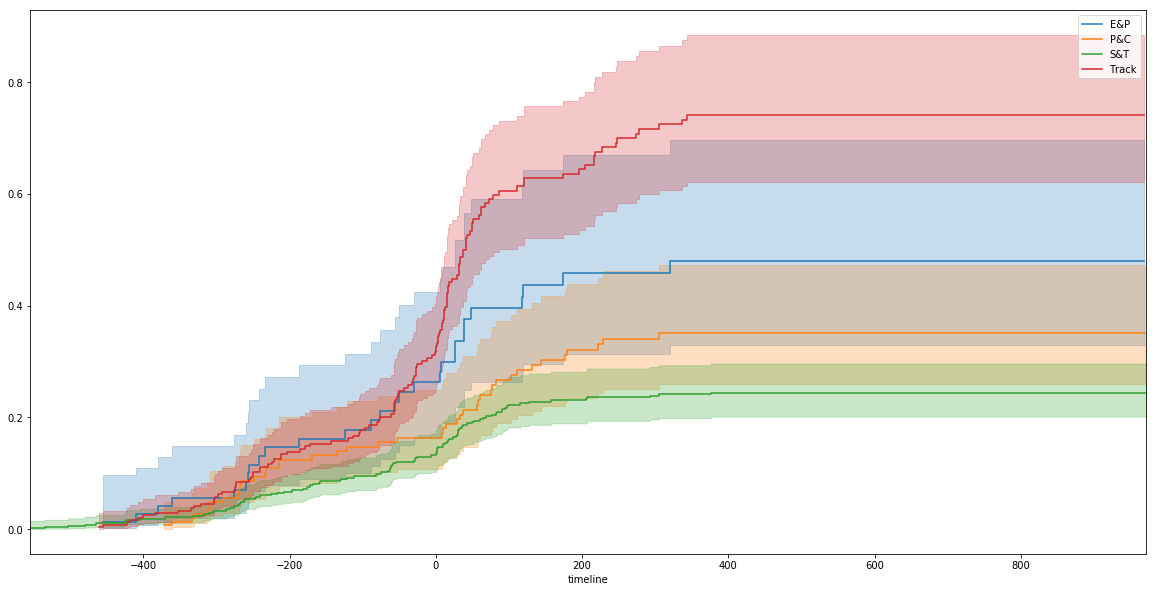

In [283]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

fig, ax = plt.subplots(figsize=(20, 10))

for name, grouped_df in df_cox2.groupby('High_Level_Asset_Class'):
    naf.fit(grouped_df["T"], grouped_df["event"], label=name)
    naf.plot(ax=ax)

In [284]:
df_cox2['Weather_24h_d']=np.nan

In [285]:
df_cox2.drop(['Weather_24h_d'], axis=1, inplace=True)

In [286]:
# min average temp 24h before death
def temp_average_24h_d_l(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=1)) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['temp_min'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=1))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['temp_min'].mean()

In [287]:
# max average temp 24h before death
def temp_average_24h_d_h(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=1)) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['temp_max'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=1))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['temp_max'].mean()

In [288]:
df_cox2['temp_24h_d_l'] = df_cox2.apply(lambda row: temp_average_24h_d_l(row), axis=1)
df_cox2['temp_24h_d_h'] = df_cox2.apply(lambda row: temp_average_24h_d_h(row), axis=1)

In [289]:
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,duration,T,weather_station,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_d_l,temp_24h_d_h
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,...,923 days 10:33:25.995877000,923.439884,Leeds,113.0,290.017000,1007.225000,87.225000,4.125000,288.569750,291.422500
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,...,785 days 08:23:27.059722000,785.349619,Manchester,101.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,...,833 days 23:03:26.026606000,833.960718,York,24.0,290.191556,1006.155556,90.444444,4.155556,288.777778,291.623778
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,...,830 days 04:27:26.108569000,830.185719,York,19.0,290.191556,1006.155556,90.444444,4.155556,288.777778,291.623778
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,...,-56 days +17:07:00.000000000,-55.286806,York,19.0,278.923750,1008.656250,96.937500,4.390625,278.103125,279.525000


In [290]:
df_cox2['temp_24h_d']= df_cox2['temp_24h_d'] - 273.15

In [291]:
df_cox2['temp_24h_d_l']= df_cox2['temp_24h_d_l'] - 273.15
df_cox2['temp_24h_d_h']= df_cox2['temp_24h_d_h'] - 273.15
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,duration,T,weather_station,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_d_l,temp_24h_d_h
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,...,923 days 10:33:25.995877000,923.439884,Leeds,113.0,16.867000,1007.225000,87.225000,4.125000,15.419750,18.272500
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,...,785 days 08:23:27.059722000,785.349619,Manchester,101.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,...,833 days 23:03:26.026606000,833.960718,York,24.0,17.041556,1006.155556,90.444444,4.155556,15.627778,18.473778
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,...,830 days 04:27:26.108569000,830.185719,York,19.0,17.041556,1006.155556,90.444444,4.155556,15.627778,18.473778
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,...,-56 days +17:07:00.000000000,-55.286806,York,19.0,5.773750,1008.656250,96.937500,4.390625,4.953125,6.375000


In [292]:
df_cox2['temp_24h_range']= df_cox2['temp_24h_d_h'] - df_cox2['temp_24h_d_l']

In [293]:
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,T,weather_station,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_d_l,temp_24h_d_h,temp_24h_range
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,...,923.439884,Leeds,113.0,16.867000,1007.225000,87.225000,4.125000,15.419750,18.272500,2.852750
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,...,785.349619,Manchester,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,...,833.960718,York,24.0,17.041556,1006.155556,90.444444,4.155556,15.627778,18.473778,2.846000
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,...,830.185719,York,19.0,17.041556,1006.155556,90.444444,4.155556,15.627778,18.473778,2.846000
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,...,-55.286806,York,19.0,5.773750,1008.656250,96.937500,4.390625,4.953125,6.375000,1.421875


In [294]:
df_cox2.describe()

,Asset_Number,event,T,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_d_l,temp_24h_d_h,temp_24h_range
count,9.390000e+02,939.000000,939.000000,647.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,2.727434e+06,0.322684,436.905493,71.471406,14.164550,1009.051965,85.510337,4.223102,12.588358,15.667612,3.079254
std,4.029192e+06,0.467752,397.615476,131.500281,4.895057,7.182254,6.675410,1.052479,4.897475,4.933589,0.626933
min,4.807500e+04,0.000000,-554.969178,1.000000,-1.227059,983.620690,41.027397,0.966667,-2.384615,-0.243243,0.000000
25%,1.012964e+06,0.000000,47.312535,14.500000,12.073437,1006.155556,85.742857,4.125000,10.520833,13.507083,2.846000
50%,1.452484e+06,0.000000,530.189897,28.000000,16.867000,1007.225000,87.225000,4.155556,15.285429,18.272500,2.852750
75%,2.439966e+06,1.000000,794.357605,103.500000,17.041556,1007.828571,89.052182,4.314286,15.419750,18.545714,3.419429
max,1.880800e+07,1.000000,971.231551,1672.000000,19.022759,1036.115385,98.618421,9.666667,17.379310,21.241379,5.837209


In [295]:
# Define functions to return average temperature, pressure, humidity and wind speeds within the last day and 7 days 
# of a 'death'
def temp_average_1w_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=7)) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['temp'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=7))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['temp'].mean()
    
def pressure_average_1w_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=7))& (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['pressure'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=7))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['pressure'].mean()
    
def humidity_average_1w_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=7))& (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['humidity'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=7))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['humidity'].mean()
      
def wind_speed_average_1w_d(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=7))& (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['wind_speed'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=7))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['wind_speed'].mean()

In [296]:
df_cox2['temp_1w_d'] = df_cox2.apply(lambda row: temp_average_1w_d(row), axis=1)
df_cox2['pressure_1w_d'] = df_cox2.apply(lambda row: pressure_average_1w_d(row), axis=1)
df_cox2['humidity_1w_d'] = df_cox2.apply(lambda row: humidity_average_1w_d(row), axis=1)
df_cox2['wind_speed_1w_d'] = df_cox2.apply(lambda row: wind_speed_average_1w_d(row), axis=1)

In [297]:
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_d_l,temp_24h_d_h,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,...,1007.225000,87.225000,4.125000,15.419750,18.272500,2.852750,291.168257,1006.838174,84.331950,3.502075
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,...,1006.155556,90.444444,4.155556,15.627778,18.473778,2.846000,291.526059,1006.055762,85.472119,3.394052
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,...,1006.155556,90.444444,4.155556,15.627778,18.473778,2.846000,291.526059,1006.055762,85.472119,3.394052
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,...,1008.656250,96.937500,4.390625,4.953125,6.375000,1.421875,280.574321,1007.780952,90.542857,3.742857


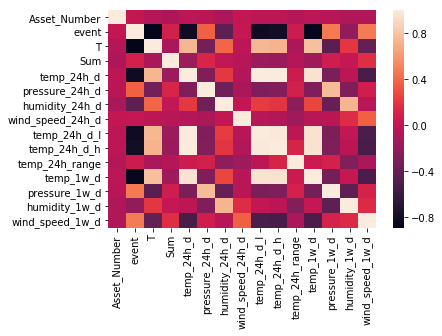

In [298]:
import seaborn as sns
corr = df_cox2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [299]:
df_cox2.drop(['temp_24h_d_l','temp_24h_d_h'], axis=1, inplace=True)

In [300]:
# min average temp 24h before death
def temp_average_1w_d_l(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=7)) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['temp_min'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=7))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['temp_min'].mean()
    
# max average temp 24h before death
def temp_average_1w_d_h(df_cox2):
    if df_cox2['event'] == 1:
        mask = (weather['dt_iso'] <= df_cox2['death']) & (weather['dt_iso'] >= df_cox2['death'] - dt.timedelta(days=7)) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask]['temp_max'].mean()
    else:
        mask2 = (weather['dt_iso'] >= (max(weather['dt_iso']) - dt.timedelta(days=7))) & (weather['city_name'] == df_cox2['weather_station'])
        return weather[mask2]['temp_max'].mean()

In [301]:
df_cox2['temp_1w_d_l'] = df_cox2.apply(lambda row: temp_average_1w_d_l(row), axis=1)
df_cox2['temp_1w_d_h'] = df_cox2.apply(lambda row: temp_average_1w_d_h(row), axis=1)

In [302]:
df_cox2['temp_1w_d']= df_cox2['temp_1w_d'] - 273.15
df_cox2['temp_1w_d_l'] = df_cox2['temp_1w_d_l'] - 273.15
df_cox2['temp_1w_d_h'] = df_cox2['temp_1w_d_h'] - 273.15

In [303]:
df_cox2['temp_1w_range']= df_cox2['temp_1w_d_h'] - df_cox2['temp_1w_d_l']

In [304]:
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_d_l,temp_1w_d_h,temp_1w_range
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,...,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,16.057386,20.081950,4.024564
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,...,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,16.312230,20.355651,4.043420
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,...,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,16.312230,20.355651,4.043420
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,...,96.937500,4.390625,1.421875,7.424321,1007.780952,90.542857,3.742857,6.321590,8.518416,2.196825


In [305]:
df_cox2.drop(['temp_1w_d_l','temp_1w_d_h'], axis=1, inplace=True)

In [306]:
df_cox2.head()

,Asset_Number,ELR,High_Level_Asset_Class,Asset_Class_Grouping,Grouping_Full_Name,Engineering_Suffix,System_Asset_Type,EQUIP_CLASS_DESC,birth,death,...,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,1011867,NOC,E&P,E&P,E&P,GENERATOR / SHORE SUPPLY,DIESEL GENERATOR SET - 650V,Diesel Alternator Set ...,2017-02-18 04:00:01,NaT,...,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
1,1648347,MVN2,E&P,E&P,E&P,TRACK CIRCUIT,TRACK CCT -DC MED VOLT AC IMMUNE,Diesel Alternator Set ...,2017-07-06 06:10:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,E&P,E&P,LEVEL CROSSING LIGHTING,LIGHTING SYSTEM - LEVEL CROSSING,Light InstalSys ...,2017-05-18 15:30:01,NaT,...,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
3,10290424,TCW1,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2017-05-22 10:06:01,NaT,...,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
4,14105964,CFM,E&P,E&P,E&P,ELECTRICAL SUPPLY POINT,ELECTRICITY SUPPLY POINT,PV - Electricity Supply Point ...,2018-06-06 20:06:00,2018-04-12 13:13:00,...,5.773750,1008.656250,96.937500,4.390625,1.421875,7.424321,1007.780952,90.542857,3.742857,2.196825


In [307]:
df_cox2['Sum']=df_cox2['Sum'].fillna(0)

In [308]:
df_cox2.isnull().sum()

Asset_Number                0
ELR                         0
High_Level_Asset_Class      0
Asset_Class_Grouping        0
Grouping_Full_Name          0
Engineering_Suffix          0
System_Asset_Type           0
EQUIP_CLASS_DESC            0
birth                       0
death                     636
event                       0
duration                    0
T                           0
weather_station             0
Sum                         0
temp_24h_d                193
pressure_24h_d            193
humidity_24h_d            193
wind_speed_24h_d          193
temp_24h_range            193
temp_1w_d                 193
pressure_1w_d             193
humidity_1w_d             193
wind_speed_1w_d           193
temp_1w_range             193
dtype: int64

In [309]:
df_cox2.columns

Index(['Asset_Number', 'ELR', 'High_Level_Asset_Class', 'Asset_Class_Grouping',
       'Grouping_Full_Name', 'Engineering_Suffix', 'System_Asset_Type',
       'EQUIP_CLASS_DESC', 'birth', 'death', 'event', 'duration', 'T',
       'weather_station', 'Sum', 'temp_24h_d', 'pressure_24h_d',
       'humidity_24h_d', 'wind_speed_24h_d', 'temp_24h_range', 'temp_1w_d',
       'pressure_1w_d', 'humidity_1w_d', 'wind_speed_1w_d', 'temp_1w_range'],
      dtype='object')

In [310]:
df_cox3 = df_cox2 [['Asset_Number', 'ELR', 'High_Level_Asset_Class','event','T',
       'weather_station', 'Sum', 'temp_24h_d', 'pressure_24h_d',
       'humidity_24h_d', 'wind_speed_24h_d', 'temp_24h_range', 'temp_1w_d',
       'pressure_1w_d', 'humidity_1w_d', 'wind_speed_1w_d', 'temp_1w_range' ]].copy()

In [311]:
df_cox3.head()

,Asset_Number,ELR,High_Level_Asset_Class,event,T,weather_station,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,1011867,NOC,E&P,0,923.439884,Leeds,113.0,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
1,1648347,MVN2,E&P,0,785.349619,Manchester,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1063020,NOC,E&P,0,833.960718,York,24.0,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
3,10290424,TCW1,E&P,0,830.185719,York,19.0,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
4,14105964,CFM,E&P,1,-55.286806,York,19.0,5.773750,1008.656250,96.937500,4.390625,1.421875,7.424321,1007.780952,90.542857,3.742857,2.196825


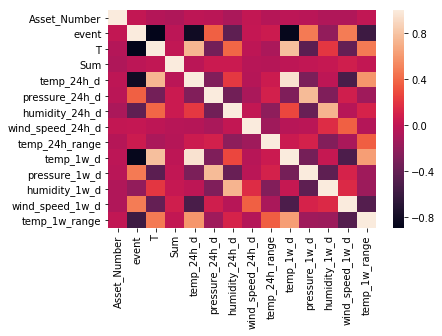

In [312]:
import seaborn as sns
corr = df_cox3.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [313]:
df_cox4 = df_cox3[['Asset_Number','event', 'T', 'Sum', 'temp_24h_d', 'pressure_24h_d',
       'humidity_24h_d', 'wind_speed_24h_d', 'temp_24h_range', 'temp_1w_d',
       'pressure_1w_d', 'humidity_1w_d', 'wind_speed_1w_d', 'temp_1w_range']].copy()

In [316]:
df_cox4['temp_24h_d'] = df_cox4['temp_24h_d'].fillna(method='bfill')
df_cox4['pressure_24h_d'] = df_cox4['pressure_24h_d'].fillna(method='bfill')
df_cox4['humidity_24h_d'] = df_cox4['humidity_24h_d'].fillna(method='bfill')
df_cox4['wind_speed_24h_d'] = df_cox4['wind_speed_24h_d'].fillna(method='bfill')
df_cox4['temp_24h_range'] = df_cox4['temp_24h_range'].fillna(method='bfill')
df_cox4['temp_1w_d'] = df_cox4['temp_1w_d'].fillna(method='bfill')
df_cox4['pressure_1w_d'] = df_cox4['pressure_1w_d'].fillna(method='bfill')
df_cox4['humidity_1w_d'] = df_cox4['humidity_1w_d'].fillna(method='bfill')
df_cox4['wind_speed_1w_d'] = df_cox4['wind_speed_1w_d'].fillna(method='bfill')
df_cox4['temp_1w_range'] = df_cox4['temp_1w_range'].fillna(method='bfill')

In [317]:
df_cox4.isnull().sum()

Asset_Number        0
event               0
T                   0
Sum                 0
temp_24h_d          0
pressure_24h_d      0
humidity_24h_d      0
wind_speed_24h_d    0
temp_24h_range      0
temp_1w_d           0
pressure_1w_d       0
humidity_1w_d       0
wind_speed_1w_d     0
temp_1w_range       0
dtype: int64

In [318]:
cph = CoxPHFitter()
cph.fit(df_cox4, 'T', 'event', cluster_col='Asset_Number',show_progress=True, step_size=0.50)
cph.print_summary()

Iteration 1: norm_delta = 2.26872, step_size = 0.5000, ll = -2018.80290, newton_decrement = 467.04082, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.82887, step_size = 0.5000, ll = -1743.79616, newton_decrement = 23.85779, seconds_since_start = 0.4
Iteration 3: norm_delta = 0.32488, step_size = 0.5000, ll = -1726.19880, newton_decrement = 4.57311, seconds_since_start = 0.4
Iteration 4: norm_delta = 0.15402, step_size = 0.6000, ll = -1722.78034, newton_decrement = 1.08348, seconds_since_start = 0.5
Iteration 5: norm_delta = 0.06033, step_size = 0.7200, ll = -1721.87146, newton_decrement = 0.16970, seconds_since_start = 0.5
Iteration 6: norm_delta = 0.01677, step_size = 0.8640, ll = -1721.71513, newton_decrement = 0.01321, seconds_since_start = 0.5
Iteration 7: norm_delta = 0.00227, step_size = 1.0000, ll = -1721.70217, newton_decrement = 0.00024, seconds_since_start = 0.6
Iteration 8: norm_delta = 0.00000, step_size = 1.0000, ll = -1721.70192, newton_decrement = 0.00000, seconds

In [319]:
cph.check_assumptions(df_cox4)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                       test_statistic      p  -log2(p)
Sum              km              4.33   0.04      4.74
                 rank            4.33   0.04      4.74
humidity_1w_d    km              3.56   0.06      4.08
                 rank            3.56   0.

In [320]:
censored_subjects = df_cox4.loc[df_cox4['event'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df_cox4.loc[c.name, 'T']]).clip_upper(1))

In [321]:
censored_subjects

,Asset_Number,event,T,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,1011867,0,923.439884,113.0,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
1,1648347,0,785.349619,101.0,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
2,1063020,0,833.960718,24.0,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
3,10290424,0,830.185719,19.0,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
7,14105964,0,841.814886,19.0,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
9,10290474,0,875.231552,18.0,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
10,10290512,0,554.210730,20.0,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
11,11352224,0,437.710731,16.0,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
14,2062044,0,918.960719,0.0,17.062571,1007.828571,85.742857,4.314286,3.340286,18.086514,1007.100917,83.247706,3.467890,3.937661
15,2410736,0,477.044063,28.0,16.940857,1007.828571,85.885714,4.314286,3.419429,17.971147,1007.119266,83.522936,3.463303,3.866835


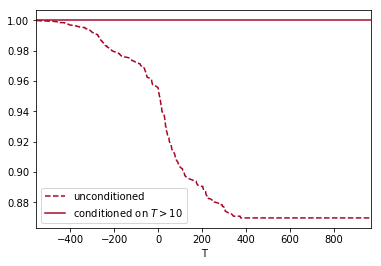

In [322]:
# let's focus on a single subject
subject = 938
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>10$")
plt.legend()

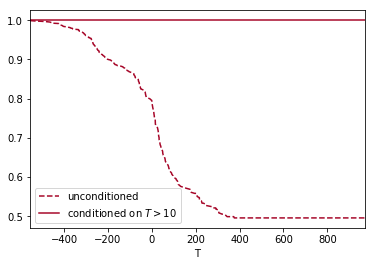

In [324]:
# let's focus on a single subject
subject = 53
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>10$")
plt.legend()

In [325]:
Y = df_cox4.drop(["T", "event"], axis=1)
cph.predict_partial_hazard(Y)

,0
0,0.399143
1,0.302157
2,0.324165
3,0.325648
4,2.041725
5,40.045476
6,9.264872
7,0.325648
8,6.896300
9,0.435310


In [326]:
#Predict the survival function for individuals, given their covariates. This assumes that the individual just
#entered the study (that is, we do not condition on how long they have already lived for.)
#time - an iterable of increasing times to predict the cumulative hazard
#at. Default is the set of all durations (observed and unobserved). Uses a linear interpolation if points in time are not in the index.

#Returns survival_function – the survival probabilities of individuals over the timeline

cph.predict_survival_function(Y, times=[5., 25., 50.,100.,500.])

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,938
5.0,0.962368,0.971379,0.969327,0.969189,0.821835,0.021312,0.410499,0.969189,0.515429,0.959028,...,0.968658,0.390158,0.958364,0.952722,0.950593,0.950593,0.848973,0.954667,0.950593,0.950593
25.0,0.952992,0.964207,0.961650,0.961478,0.781690,0.007981,0.327052,0.961478,0.435217,0.948843,...,0.960817,0.306840,0.948017,0.941017,0.938379,0.938379,0.814226,0.943429,0.938379,0.938379
50.0,0.939407,0.953784,0.950503,0.950282,0.726341,0.001890,0.234363,0.950282,0.339608,0.934102,...,0.949434,0.215736,0.933047,0.924113,0.920751,0.920751,0.765829,0.927189,0.920751,0.920751
100.0,0.925835,0.943334,0.939335,0.939066,0.674234,0.000439,0.167180,0.939066,0.264105,0.919393,...,0.938033,0.150954,0.918114,0.907287,0.903220,0.903220,0.719706,0.911012,0.903220,0.903220
500.0,0.899682,0.923092,0.917727,0.917366,0.582309,0.000025,0.085965,0.917366,0.160977,0.891105,...,0.915983,0.074730,0.889405,0.875048,0.869671,0.869671,0.636850,0.879981,0.869671,0.869671


In [327]:
import patsy
X = patsy.dmatrix('Asset_Number + High_Level_Asset_Class + event + T + weather_station + Sum + temp_24h_d + pressure_24h_d + humidity_24h_d + wind_speed_24h_d + temp_24h_range + temp_1w_d + pressure_1w_d + humidity_1w_d + wind_speed_1w_d + temp_1w_range', df_cox3, return_type='dataframe')

X

,Intercept,High_Level_Asset_Class[T.P&C],High_Level_Asset_Class[T.S&T],High_Level_Asset_Class[T.Track],weather_station[T.Leeds],weather_station[T.Manchester],weather_station[T.Mirfield],weather_station[T.York],Asset_Number,event,...,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1011867.0,0.0,...,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1063020.0,0.0,...,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10290424.0,0.0,...,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14105964.0,1.0,...,5.773750,1008.656250,96.937500,4.390625,1.421875,7.424321,1007.780952,90.542857,3.742857,2.196825
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14105964.0,1.0,...,7.305600,1008.120000,69.160000,9.200000,4.200000,4.939188,1019.209402,81.927350,4.111111,4.512821
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14105964.0,1.0,...,8.457200,1012.280000,71.320000,2.800000,2.880000,9.084438,1021.171598,69.994083,4.000000,3.218935
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14105964.0,0.0,...,17.041556,1006.155556,90.444444,4.155556,2.846000,18.376059,1006.055762,85.472119,3.394052,4.043420
8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10290512.0,1.0,...,4.955074,1026.333333,85.962963,2.814815,1.777778,5.449891,1016.895652,86.460870,3.817391,2.769565
9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10290474.0,0.0,...,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564
10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10290512.0,0.0,...,16.867000,1007.225000,87.225000,4.125000,2.852750,18.018257,1006.838174,84.331950,3.502075,4.024564


In [328]:
X.columns

Index(['Intercept', 'High_Level_Asset_Class[T.P&C]',
       'High_Level_Asset_Class[T.S&T]', 'High_Level_Asset_Class[T.Track]',
       'weather_station[T.Leeds]', 'weather_station[T.Manchester]',
       'weather_station[T.Mirfield]', 'weather_station[T.York]',
       'Asset_Number', 'event', 'T', 'Sum', 'temp_24h_d', 'pressure_24h_d',
       'humidity_24h_d', 'wind_speed_24h_d', 'temp_24h_range', 'temp_1w_d',
       'pressure_1w_d', 'humidity_1w_d', 'wind_speed_1w_d', 'temp_1w_range'],
      dtype='object')

In [329]:
del X['Intercept']

In [330]:
cph = CoxPHFitter()
cph.fit(X, 'T', 'event', cluster_col='Asset_Number',show_progress=True, step_size=0.50)
cph.print_summary()

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Matrix is singular.

In [331]:
cph.predict_survival_function(X, times=[1., 5., 25., 50.,100.,500.,637.])

AttributeError: 'CoxPHFitter' object has no attribute 'baseline_cumulative_hazard_'

In [156]:
cph.predict_expectation(X)

,0
0,713.721442
1,57.358683
2,129.018470
3,86.165981
4,713.721442
5,102.022357
6,626.615683
7,146.292498
8,626.615683
9,626.615683


In [ ]:
X

In [ ]:
X.to_csv('df_cox_dummy.csv')

In [186]:
df_cox3.loc[df_cox3['High_Level_Asset_Class'] == 'Fences and Barriers','High_Level_Asset_Class']= 'S&T'

In [189]:
df_cox3.loc[df_cox3['High_Level_Asset_Class'] == 'Structures','High_Level_Asset_Class']= 'Track'

In [190]:
df_cox3

,Asset_Number,ELR,High_Level_Asset_Class,event,T,weather_station,Sum,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,48075,DOL2,Track,0,267.106203,Leeds,0.0,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
1,48081,DOL2,Track,1,0.791435,Leeds,0.0,10.112222,1016.814815,84.740741,7.777778,4.000000,9.153670,1022.569149,77.978723,4.845745,4.909574
2,48081,DOL2,Track,1,40.656933,Leeds,0.0,15.914231,1015.269231,86.076923,2.192308,3.961538,15.376759,1014.699074,87.490741,3.263889,4.300926
3,48081,DOL2,Track,1,203.419444,Leeds,0.0,7.668974,1032.256410,93.384615,7.564103,4.846154,5.730562,1028.638554,91.698795,4.686747,4.148594
4,48081,DOL2,Track,0,443.199953,Leeds,0.0,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
5,48353,ECM3,Track,1,178.318056,York,0.0,15.477200,1023.480000,70.840000,2.360000,3.040000,10.446955,1014.374302,75.474860,4.212291,2.435754
6,48353,ECM3,Track,0,308.841620,York,0.0,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218
7,48354,ECM3,Track,1,173.954861,York,0.0,7.551250,1031.291667,82.833333,5.541667,1.916667,3.979209,1020.770053,85.582888,5.128342,2.310160
8,48354,ECM3,Track,0,460.845787,York,0.0,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218
9,48355,ECM4,Track,0,596.338148,York,0.0,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218


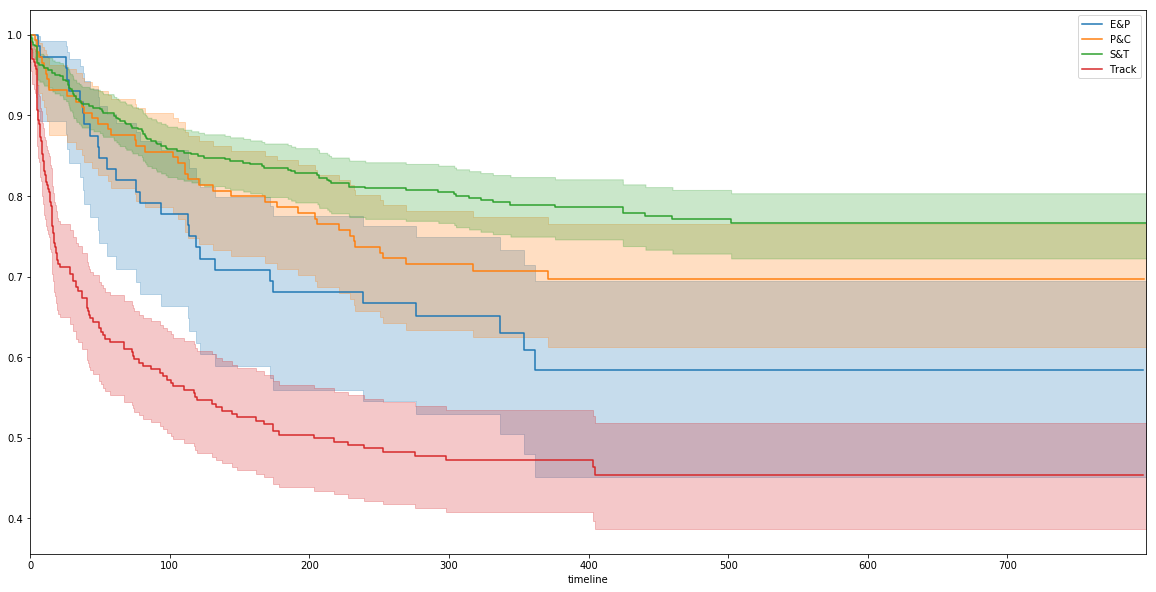

In [196]:
# KM curve for Multiple asset classess
fig, ax = plt.subplots(figsize=(20, 10))

kmf = KaplanMeierFitter()

for name, grouped_df in df_cox3.groupby('High_Level_Asset_Class'):
    kmf.fit(grouped_df["T"], grouped_df["event"], label=name)
    kmf.plot(ax=ax)


In [192]:
import patsy
X1 = patsy.dmatrix('Asset_Number + High_Level_Asset_Class + event + T + weather_station + Sum + temp_24h_d + pressure_24h_d + humidity_24h_d + wind_speed_24h_d + temp_24h_range + temp_1w_d + pressure_1w_d + humidity_1w_d + wind_speed_1w_d + temp_1w_range', df_cox3, return_type='dataframe')

X1

,Intercept,High_Level_Asset_Class[T.P&C],High_Level_Asset_Class[T.S&T],High_Level_Asset_Class[T.Track],weather_station[T.Leeds],weather_station[T.Manchester],weather_station[T.Mirfield],weather_station[T.York],Asset_Number,event,...,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,48075.0,0.0,...,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,48081.0,1.0,...,10.112222,1016.814815,84.740741,7.777778,4.000000,9.153670,1022.569149,77.978723,4.845745,4.909574
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,48081.0,1.0,...,15.914231,1015.269231,86.076923,2.192308,3.961538,15.376759,1014.699074,87.490741,3.263889,4.300926
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,48081.0,1.0,...,7.668974,1032.256410,93.384615,7.564103,4.846154,5.730562,1028.638554,91.698795,4.686747,4.148594
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,48081.0,0.0,...,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48353.0,1.0,...,15.477200,1023.480000,70.840000,2.360000,3.040000,10.446955,1014.374302,75.474860,4.212291,2.435754
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48353.0,0.0,...,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48354.0,1.0,...,7.551250,1031.291667,82.833333,5.541667,1.916667,3.979209,1020.770053,85.582888,5.128342,2.310160
8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48354.0,0.0,...,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218
9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48355.0,0.0,...,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218


In [193]:
del X1['Intercept']

In [194]:
cph = CoxPHFitter()
cph.fit(X1, 'T', 'event', cluster_col='Asset_Number',show_progress=True, step_size=0.50)
cph.print_summary()

Iteration 1: norm_delta = 1.60353, step_size = 0.5000, ll = -2008.34655, newton_decrement = 626.77106, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.26693, step_size = 0.5000, ll = -1686.24044, newton_decrement = 19.60673, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.13075, step_size = 0.5000, ll = -1671.59639, newton_decrement = 4.69602, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.07935, step_size = 0.6000, ll = -1668.07190, newton_decrement = 1.19315, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.03855, step_size = 0.7200, ll = -1667.06853, newton_decrement = 0.19503, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.01308, step_size = 0.8640, ll = -1666.88862, newton_decrement = 0.01559, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00207, step_size = 1.0000, ll = -1666.87331, newton_decrement = 0.00029, seconds_since_start = 0.2
Iteration 8: norm_delta = 0.00000, step_size = 1.0000, ll = -1666.87302, newton_decrement = 0.00000, seconds

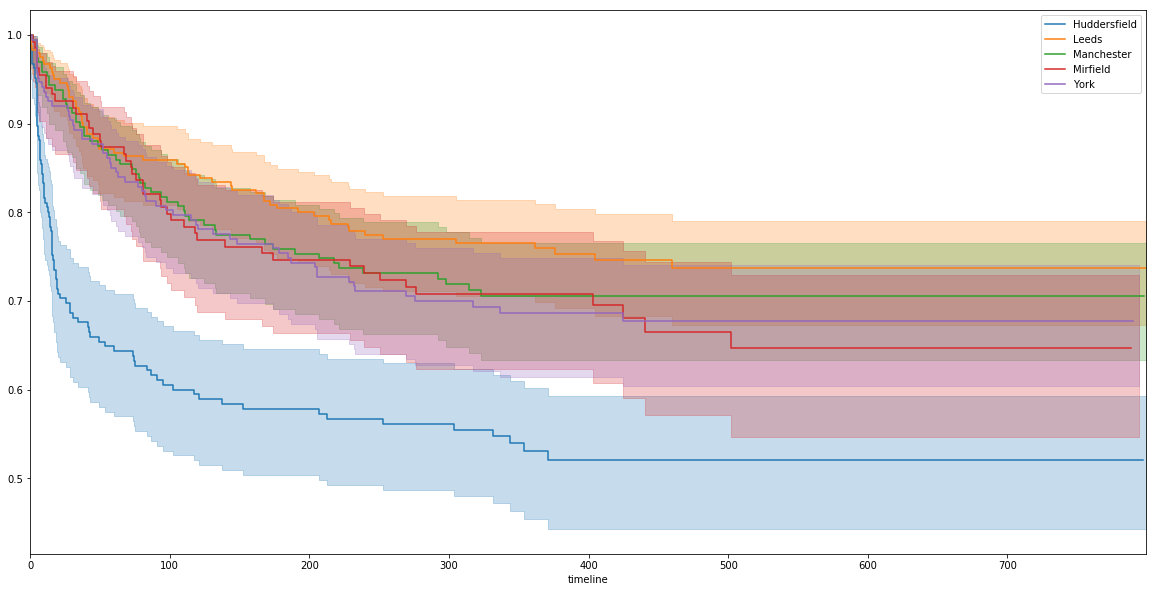

In [197]:
fig, ax = plt.subplots(figsize=(20, 10))

kmf = KaplanMeierFitter()

for name, grouped_df in df_cox3.groupby('weather_station'):
    kmf.fit(grouped_df["T"], grouped_df["event"], label=name)
    kmf.plot(ax=ax)


In [199]:
prediction = cph.predict_survival_function(X1, times=[1., 5., 25., 50.,100.,343., 500.,637.])
prediction

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,936,937,938,939
1.0,0.999120,0.969989,0.982778,0.977106,0.999120,0.979719,0.998077,0.984233,0.998077,0.998077,...,0.998945,0.999517,0.999517,0.999516,0.998991,0.998847,0.999517,0.999517,0.999517,0.999343
5.0,0.993952,0.810685,0.887228,0.852552,0.993952,0.868376,0.986827,0.896314,0.986827,0.986827,...,0.992757,0.996678,0.996677,0.996674,0.993074,0.992084,0.996680,0.996678,0.996679,0.995482
25.0,0.981771,0.529131,0.695663,0.616435,0.981771,0.651795,0.960582,0.717495,0.960582,0.960582,...,0.978195,0.989958,0.989957,0.989948,0.979141,0.976186,0.989965,0.989959,0.989961,0.986360
50.0,0.968355,0.328708,0.530306,0.429280,0.968355,0.473240,0.932119,0.559737,0.932119,0.932119,...,0.962198,0.982513,0.982511,0.982495,0.963826,0.958746,0.982526,0.982516,0.982519,0.976280
100.0,0.950106,0.170191,0.364372,0.260289,0.950106,0.303981,0.894148,0.397083,0.894148,0.894148,...,0.940508,0.972312,0.972308,0.972284,0.943043,0.935144,0.972332,0.972316,0.972320,0.962511
343.0,0.886508,0.015484,0.092901,0.042089,0.886508,0.060644,0.768482,0.113735,0.768482,0.768482,...,0.865574,0.936048,0.936039,0.935984,0.871075,0.853999,0.936094,0.936058,0.936067,0.913993
500.0,0.864610,0.006517,0.056722,0.021803,0.864610,0.033889,0.727593,0.072423,0.727593,0.727593,...,0.840015,0.923292,0.923281,0.923216,0.846466,0.826468,0.923347,0.923303,0.923314,0.897085
637.0,0.861307,0.005709,0.052597,0.019715,0.861307,0.031002,0.721530,0.067589,0.721530,0.721530,...,0.836171,0.921355,0.921344,0.921277,0.842762,0.822334,0.921411,0.921367,0.921378,0.894525


In [200]:
prediction.to_csv('Cox_predicition.csv')

In [201]:
df_cox3.to_csv('df_cox_master_v1.0.csv')

In [205]:
min(dfcox['death'])


NaT

In [6]:
X1= pd.read_csv('df_cox_dummy.csv')

In [7]:
cph = CoxPHFitter()
cph.fit(X1, 'T', 'event', cluster_col='Asset_Number',show_progress=True, step_size=0.50)
cph.print_summary()

C:\Users\jialitao\AppData\Local\Continuum\anaconda3\lib\site-packages\lifelines\utils\__init__.py:862: ConvergenceWarning: Column(s) High_Level_Asset_Class[T.Structures] have very low variance when conditioned on
death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['event'].astype(bool)
>>> df.loc[events, 'High_Level_Asset_Class[T.Structures]'].var()
>>> df.loc[~events, 'High_Level_Asset_Class[T.Structures]'].var()

Too low variance here means that the column High_Level_Asset_Class[T.Structures] completely determines whether a subject dies or not. 
See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/ 
  warnings.warn(warning_text, ConvergenceWarning)


Iteration 1: norm_delta = 1.61717, step_size = 0.5000, ll = -2008.34655, newton_decrement = 628.17908, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.27556, step_size = 0.5000, ll = -1685.75909, newton_decrement = 19.60189, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.13088, step_size = 0.5000, ll = -1671.14654, newton_decrement = 4.54701, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.08033, step_size = 0.6000, ll = -1667.73545, newton_decrement = 1.15065, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.04441, step_size = 0.7200, ll = -1666.76710, newton_decrement = 0.19398, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.03099, step_size = 0.8640, ll = -1666.58709, newton_decrement = 0.01977, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.03270, step_size = 1.0000, ll = -1666.56676, newton_decrement = 0.00246, seconds_since_start = 0.2
Iteration 8: norm_delta = 0.03196, step_size = 0.9800, ll = -1666.56372, newton_decrement = 0.00081, seconds

In [9]:
X1.head()

,High_Level_Asset_Class[T.Fences and Barriers],High_Level_Asset_Class[T.P&C],High_Level_Asset_Class[T.S&T],High_Level_Asset_Class[T.Structures],High_Level_Asset_Class[T.Track],weather_station[T.Leeds],weather_station[T.Manchester],weather_station[T.Mirfield],weather_station[T.York],Asset_Number,...,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,0,0,0,0,1,1,0,0,0,48075,...,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
1,0,0,0,0,1,1,0,0,0,48081,...,10.112222,1016.814815,84.740741,7.777778,4.000000,9.153670,1022.569149,77.978723,4.845745,4.909574
2,0,0,0,0,1,1,0,0,0,48081,...,15.914231,1015.269231,86.076923,2.192308,3.961538,15.376759,1014.699074,87.490741,3.263889,4.300926
3,0,0,0,0,1,1,0,0,0,48081,...,7.668974,1032.256410,93.384615,7.564103,4.846154,5.730562,1028.638554,91.698795,4.686747,4.148594
4,0,0,0,0,1,1,0,0,0,48081,...,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835


In [38]:
prediction = cph.predict_survival_function(X1, times=[1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97., 98., 99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215., 216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229., 230., 231., 232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245., 246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260., 261., 262., 263., 264., 265., 266., 267., 268., 269., 270., 271., 272., 273., 274., 275., 276., 277., 278., 279., 280., 281., 282., 283., 284., 285., 286., 287., 288., 289., 290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300., 301., 302., 303., 304., 305., 306., 307., 308., 309., 310., 311., 312., 313., 314., 315., 316., 317., 318., 319., 320., 321., 322., 323., 324., 325., 326., 327., 328., 329., 330., 331., 332., 333., 334., 335., 336., 337., 338., 339., 340., 341., 342., 343., 344., 345., 346., 347., 348., 349., 350., 351., 352., 353., 354., 355., 356., 357., 358., 359., 360., 361., 362., 363., 364., 365., 366., 367., 368., 369., 370., 371., 372., 373., 374., 375., 376., 377., 378., 379., 380., 381., 382., 383., 384., 385., 386., 387., 388., 389., 390., 391., 392., 393., 394., 395., 396., 397., 398., 399., 400., 401., 402., 403., 404., 405., 406., 407., 408., 409., 410., 411., 412., 413., 414., 415., 416., 417., 418., 419., 420., 421., 422., 423., 424., 425., 426., 427., 428., 429., 430., 431., 432., 433., 434., 435., 436., 437., 438., 439., 440., 441., 442., 443., 444., 445., 446., 447., 448., 449., 450., 451., 452., 453., 454., 455., 456., 457., 458., 459., 460., 461., 462., 463., 464., 465., 466., 467., 468., 469., 470., 471., 472., 473., 474., 475., 476., 477., 478., 479., 480., 481., 482., 483., 484., 485., 486., 487., 488., 489., 490., 491., 492., 493., 494., 495., 496., 497., 498., 499., 500., 501., 502., 503., 504., 505., 506., 507., 508., 509., 510., 511., 512., 513., 514., 515., 516., 517., 518., 519., 520., 521., 522., 523., 524., 525., 526., 527., 528., 529., 530., 531., 532., 533., 534., 535., 536., 537., 538., 539., 540., 541., 542., 543.])
prediction

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,936,937,938,939
1.0,0.999116,0.970022,0.982755,0.977169,0.999116,0.979651,0.998083,0.984281,0.998083,0.998083,...,0.998943,0.999513,0.999513,0.999512,0.998981,0.998844,0.999513,0.999513,0.999513,0.999341
2.0,0.998349,0.944697,0.968009,0.957749,0.998349,0.962302,0.996419,0.970820,0.996419,0.996419,...,0.998026,0.999089,0.999089,0.999088,0.998096,0.997840,0.999090,0.999089,0.999089,0.998768
3.0,0.997953,0.931894,0.960489,0.947882,0.997953,0.953472,0.995562,0.963949,0.995562,0.995562,...,0.997553,0.998871,0.998871,0.998870,0.997640,0.997323,0.998872,0.998871,0.998871,0.998473
4.0,0.997529,0.918383,0.952505,0.937436,0.997529,0.944113,0.994646,0.956648,0.994646,0.994646,...,0.997047,0.998637,0.998637,0.998636,0.997152,0.996770,0.998638,0.998637,0.998637,0.998157
5.0,0.993928,0.810870,0.887083,0.852924,0.993928,0.867961,0.986868,0.896614,0.986868,0.986868,...,0.992743,0.996647,0.996647,0.996644,0.993002,0.992065,0.996650,0.996648,0.996648,0.995467
6.0,0.993155,0.789461,0.873621,0.835781,0.993155,0.852415,0.985204,0.884213,0.985204,0.985204,...,0.991821,0.996220,0.996220,0.996217,0.992112,0.991056,0.996223,0.996221,0.996221,0.994890
7.0,0.992374,0.768370,0.860204,0.818782,0.992374,0.836965,0.983523,0.871836,0.983523,0.983523,...,0.990888,0.995788,0.995788,0.995784,0.991213,0.990037,0.995791,0.995789,0.995790,0.994306
8.0,0.991802,0.753264,0.850498,0.806537,0.991802,0.825814,0.982293,0.862872,0.982293,0.982293,...,0.990205,0.995472,0.995471,0.995467,0.990554,0.989290,0.995475,0.995472,0.995473,0.993879
9.0,0.990728,0.725698,0.832568,0.784040,0.990728,0.805278,0.979986,0.846288,0.979986,0.979986,...,0.988923,0.994877,0.994877,0.994872,0.989317,0.987890,0.994881,0.994878,0.994879,0.993076
10.0,0.989818,0.703103,0.817652,0.765446,0.989818,0.788256,0.978033,0.832468,0.978033,0.978033,...,0.987837,0.994373,0.994373,0.994368,0.988270,0.986703,0.994377,0.994374,0.994375,0.992395


In [28]:
X1

,High_Level_Asset_Class[T.Fences and Barriers],High_Level_Asset_Class[T.P&C],High_Level_Asset_Class[T.S&T],High_Level_Asset_Class[T.Structures],High_Level_Asset_Class[T.Track],weather_station[T.Leeds],weather_station[T.Manchester],weather_station[T.Mirfield],weather_station[T.York],Asset_Number,...,temp_24h_d,pressure_24h_d,humidity_24h_d,wind_speed_24h_d,temp_24h_range,temp_1w_d,pressure_1w_d,humidity_1w_d,wind_speed_1w_d,temp_1w_range
0,0,0,0,0,1,1,0,0,0,48075,...,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
1,0,0,0,0,1,1,0,0,0,48081,...,10.112222,1016.814815,84.740741,7.777778,4.000000,9.153670,1022.569149,77.978723,4.845745,4.909574
2,0,0,0,0,1,1,0,0,0,48081,...,15.914231,1015.269231,86.076923,2.192308,3.961538,15.376759,1014.699074,87.490741,3.263889,4.300926
3,0,0,0,0,1,1,0,0,0,48081,...,7.668974,1032.256410,93.384615,7.564103,4.846154,5.730562,1028.638554,91.698795,4.686747,4.148594
4,0,0,0,0,1,1,0,0,0,48081,...,2.343913,1008.478261,94.326087,3.173913,2.543478,4.616942,1009.626214,85.330097,5.538835,2.538835
5,0,0,0,0,1,0,0,0,1,48353,...,15.477200,1023.480000,70.840000,2.360000,3.040000,10.446955,1014.374302,75.474860,4.212291,2.435754
6,0,0,0,0,1,0,0,0,1,48353,...,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218
7,0,0,0,0,1,0,0,0,1,48354,...,7.551250,1031.291667,82.833333,5.541667,1.916667,3.979209,1020.770053,85.582888,5.128342,2.310160
8,0,0,0,0,1,0,0,0,1,48354,...,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218
9,0,0,0,0,1,0,0,0,1,48355,...,2.389773,1008.886364,91.954545,3.204545,2.159091,4.751683,1009.732673,82.257426,5.059406,2.178218


In [39]:
prediction.to_csv('prob_prediction_v0.2.csv')